# Photon Transport Simulation in a Water Phantom

In this notebook, we simulate the transport of photons through a water phantom. The photons interact with the phantom material, depositing energy in the form of dose. We simulate four main types of photon interactions: Compton scattering, photoelectric absorption, Rayleigh scattering, and pair production.

We will use the Monte Carlo method to simulate the transport of a large number of photons and track the energy deposition in a 3D voxel grid representing the phantom.

## Constants and Initialization

We define several constants related to the photon energy, phantom size, and voxel size. These constants are used throughout the simulation. We also initialize the 3D grid (`dose`) to track the energy deposition for each voxel.

The phantom is assumed to have a size of `10x10x10` cm, and we divide it into smaller "voxels" to simulate energy deposition at discrete points in space.


In [1]:
import numpy as np

In [2]:
# Constants
photon_energy = 10.0  # Initial photon energy (10 MeV)
num_photons = 100000  # Total number of photons to simulate
water_density = 1.0  # Density of water in g/cm^3 (approximate)
voxel_size = 0.5  # Voxel size in cm
phantom_size = 10  # Dimensions of the phantom (10x10x10 cm)
num_voxels = int(phantom_size / voxel_size)  # Number of voxels along each axis

# Initialize the dose grid (3D array) to track energy deposition
dose = np.zeros((num_voxels, num_voxels, num_voxels))

## Photon Interaction Functions

The main photon interactions we simulate are:

- **Compton Scattering**: A photon scatters off an electron, losing energy in the process.
- **Photoelectric Absorption**: The photon is fully absorbed by an electron in the material.
- **Rayleigh Scattering**: An elastic scattering where the photon does not lose energy.
- **Pair Production**: For high-energy photons, the photon can produce an electron-positron pair, reducing its energy.

Each function simulates one of these interactions and returns the updated photon energy after the interaction.


In [3]:
# Function definitions for different photon interactions

def compton_scatter(photon_energy):
    """
    Simulate a Compton scattering event.
    The energy loss depends on the scattering angle.
    """
    angle = np.random.uniform(0, np.pi)
    energy_loss = photon_energy * (1 - np.cos(angle)) / (1 + photon_energy / 0.511)  # Simplified Compton formula
    return max(photon_energy - energy_loss, 0)  # Return updated photon energy after scattering

def photoelectric_absorption(photon_energy):
    """ 
    Simulate photoelectric absorption (photon is fully absorbed).
    The photon energy becomes zero.
    """
    return 0  # Photon is completely absorbed

def rayleigh_scatter(photon_energy):
    """
    Simulate Rayleigh scattering (elastic scattering).
    Photon energy remains unchanged after scattering.
    """
    return photon_energy  # No energy loss during Rayleigh scattering

def pair_production(photon_energy):
    """ 
    Simulate pair production for photons with energy above 1.022 MeV.
    Energy is reduced by the threshold required for pair production.
    """
    if photon_energy > 1.022:
        energy_loss = 1.022  # Minimum energy required for pair production
        return photon_energy - energy_loss
    return photon_energy  # No pair production if photon energy is below threshold

## Simulating Photon Transport

The `simulate_photon` function simulates the movement and interactions of a photon through the phantom. The photon is initialized at a random position and interacts with the material until its energy drops to zero.

- The interaction type is chosen randomly based on predefined probabilities for each interaction.
- After each interaction, the photon’s energy is updated.
- The energy is deposited into the corresponding voxel based on the photon’s position in the phantom.
- The photon then moves to a new position within the phantom, and the process repeats until the photon is absorbed or loses all its energy.

The total energy deposited by each photon is accumulated for normalization.


In [4]:
def simulate_photon():
    """
    Simulate the transport of a single photon through the phantom.
    The photon interacts with the phantom and deposits energy in voxels.
    """
    energy = photon_energy  # Start with initial photon energy
    position = np.array([np.random.uniform(0, phantom_size) for _ in range(3)])  # Initial photon position in 3D space
    total_energy_deposited = 0  # Total energy deposited by the photon during its path

    while energy > 0:  # Continue until photon energy is exhausted
        # Randomly choose an interaction type with given probabilities
        interaction_type = np.random.choice(
            ['compton', 'photoelectric', 'rayleigh', 'pair'], 
            p=[0.6, 0.2, 0.1, 0.1]
        )
        
        # Update photon energy based on interaction type
        if interaction_type == 'compton':
            energy = compton_scatter(energy)
        elif interaction_type == 'photoelectric':
            energy = photoelectric_absorption(energy)
        elif interaction_type == 'rayleigh':
            energy = rayleigh_scatter(energy)
        elif interaction_type == 'pair':
            energy = pair_production(energy)
        
        # Calculate the voxel index based on the photon's position
        voxel_idx = np.floor(position / voxel_size).astype(int)
        voxel_idx = np.clip(voxel_idx, 0, num_voxels - 1)  # Ensure the voxel indices are within bounds
        
        # Deposit energy in the corresponding voxel
        dose[tuple(voxel_idx)] += energy
        total_energy_deposited += energy
        
        # Move the photon to a new random position within the phantom
        position += np.random.uniform(-0.1, 0.1, size=3)  # Small random displacement in 3D space
        position = np.clip(position, 0, phantom_size)  # Ensure position stays within phantom boundaries
        
    return total_energy_deposited  # Return total energy deposited by this photon

## Running the Simulation

Now that we have defined the interaction functions and photon transport logic, we can simulate the transport of many photons through the phantom. Each photon’s energy deposition is tracked, and the total energy deposited in the phantom is normalized.

Finally, we calculate the mean and standard deviation of the energy dose distribution across all voxels in the phantom.


In [5]:
# Simulate transport for multiple photons
total_energy_in_phantom = 0  # Track the total energy deposited in the phantom

# Simulate each photon and accumulate the energy deposited
for _ in range(num_photons):
    total_energy_in_phantom += simulate_photon()

# Normalize the dose distribution by the total energy deposited in the phantom
dose /= total_energy_in_phantom

# Calculate and print the mean and standard deviation of the dose distribution
mean_dose = np.mean(dose)
std_dose = np.std(dose)

# Output the results
print(f"Mean Dose: {mean_dose:.4f} Gy")
print(f"Standard Deviation of Dose: {std_dose:.4f} Gy")

Mean Dose: 0.0001 Gy
Standard Deviation of Dose: 0.0000 Gy


## Results

We have successfully simulated the photon transport and energy deposition in a water phantom. Below are the results:

- **Mean Dose**: The average energy deposited in the phantom.
- **Standard Deviation of Dose**: The spread of energy deposition values across the voxels.

These values help us understand the dose distribution within the phantom.


# Visualizing Dose Distribution in 3D Phantom

In this section, we visualize the dose distribution in the 3D phantom by plotting slices of the dose matrix. We will display three different slices of the phantom at various positions along the Z-axis.

Each slice represents the dose distribution in a 2D plane, and we will use a heatmap to represent the dose levels across the X and Y axes. This helps us observe the spatial distribution of energy deposition in the phantom.

We will display three slices of the dose distribution at different Z positions: the middle, a quarter of the way, and three-quarters of the way through the phantom.


## Code to Plot Dose Distribution Slices

The code below creates a 1x3 grid of subplots where each subplot shows a different slice of the dose distribution. We select three slices along the Z-axis and plot them using a heatmap with the `imshow` function.


In [6]:
import matplotlib.pyplot as plt

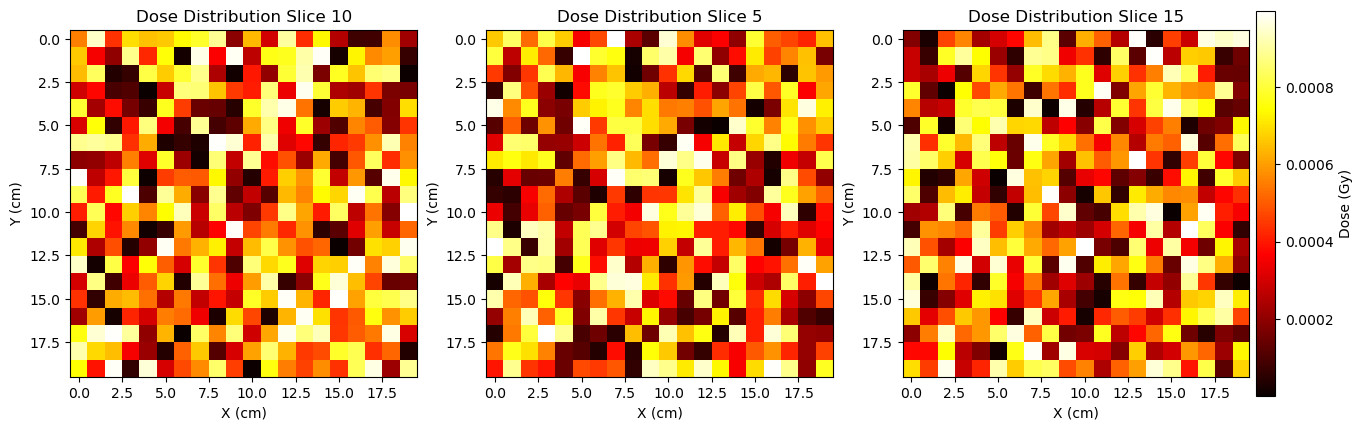

In [13]:
# Simulating dose data
num_voxels = 20
dose = np.random.rand(num_voxels, num_voxels, num_voxels) * 1e-3  # Random data scaled for demonstration

# Plot multiple slices of the dose distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Increase figsize to make space for color bar

slices = [num_voxels // 2, num_voxels // 4, 3 * num_voxels // 4]  # Slice positions at 50%, 25%, and 75%

# Loop over the selected slices and plot them
for i, slice_idx in enumerate(slices):
    im = axes[i].imshow(dose[:, :, slice_idx], cmap='hot', interpolation='nearest')  # Plot slice
    axes[i].set_title(f'Dose Distribution Slice {slice_idx}')  # Set subplot title
    axes[i].set_xlabel('X (cm)')  # Label X axis
    axes[i].set_ylabel('Y (cm)')  # Label Y axis

# Add a single color bar for the entire figure on the left side
cbar = plt.colorbar(im, ax=axes, orientation='vertical', pad=0.02)  # Adjust pad to prevent overlap
cbar.set_label('Dose (Gy)')  # Label for the color bar

# Adjust layout manually for better spacing
plt.subplots_adjust(right=.78)  # Move the subplots to the left to give space for the colorbar

# Show the plots

plt.savefig('plots/dose_distribution_slices.pdf', format='pdf')
plt.show()

## Histogram that shows the uniformity of the dose distribution

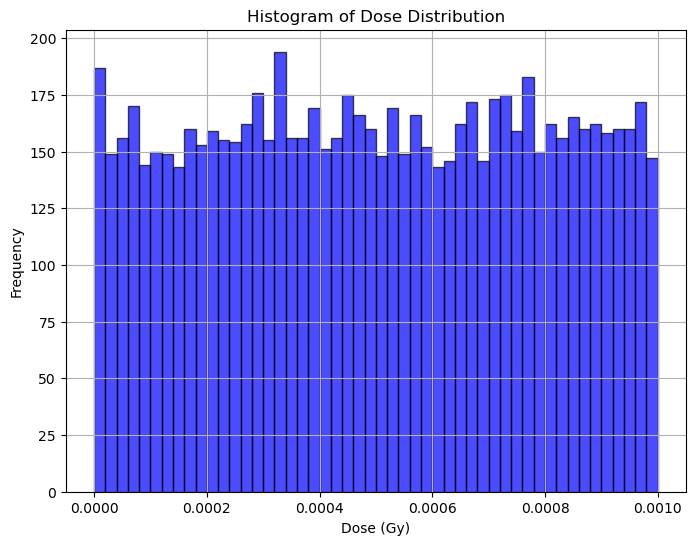

In [12]:
# Plot the histogram of the dose distribution
plt.figure(figsize=(8, 6))
plt.hist(dose.flatten(), bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Dose Distribution')
plt.xlabel('Dose (Gy)')
plt.ylabel('Frequency')
plt.grid(True)

plt.savefig('plots/dose_distribution_HG.pdf', format='pdf')
plt.show()